# Ch7. Learning from images
---
>- 순방향 신경망 만들기
>- `Dataset`과 `Dataloader`를 사용한 데이터 로딩
>- 분류 손실

'CIFAR-10' 이미지 셋을 이용해서 이미지 분류를 진행한다.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets
data_path = 'data/data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)


C:\Users\soso6\miniconda3\envs\Deeplearning with PyTorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

<function matplotlib.pyplot.show(close=None, block=None)>

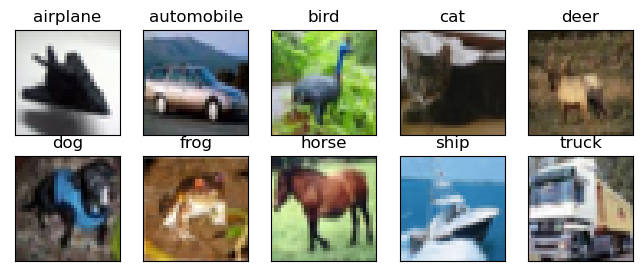

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = len(class_names)
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)

plt.show

In [5]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

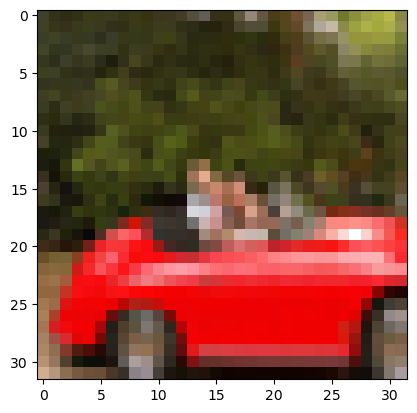

In [6]:
plt.imshow(img)
plt.show()

PIL로 불러온 이미지 데이터를 텐서로 바꾸기 위해서 `torchvision.transforms` 라이브러리를 이용한다.
그 중에서도 $C \times H \times W$ 형태로 맞춰주는 `ToTensor`를 이용해서 진행한다.

In [7]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [8]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

`dataset`에서 불러올 때 처음부터 `tranformer`를 전달해줄 수 있다.

In [9]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

In [10]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [11]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

텐서로 변환한 후 값도 0과 1사이로 스케일링된 것을 알 수 있다.

In [12]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

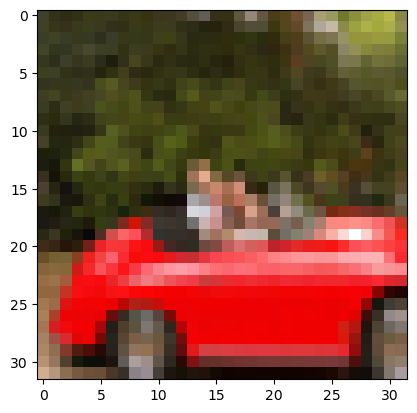

In [13]:
plt.imshow(img_t.permute(1,2,0)) # Matplotlib 형식에 맞게 H X W X C 형태로 바꿔줌
plt.show()

데이터셋을 정규화하기 위해 `transforms.Normalize`를 이용한다.
>-정규화를 하는 이유
>   - 뉴런이 0이 아닌 기울기를 갖게 되므로 **학습속도 향상**
>   - 채널 정보가 **동일한 학습률**로 업데이트

각 채널의 `mean`과 `std`는 따로 구해서 `Normalize`에 넣어야한다.

In [14]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

`view(3, -1)`은 세 채널은 유지하고 나머지 차원을 하나로 합친다. 그 결과 3$\times$1024 형태로 바뀌고 `mean`과 `std`는 각 채널의 1024개에 대해서 계산하게 된다.

In [15]:
imgs_mean = imgs.view(3,-1).mean(dim=1)


In [16]:
imgs_std = imgs.view(3,-1).std(dim=1)

imgs.shape, imgs.view(3,-1).shape

(torch.Size([3, 32, 32, 50000]), torch.Size([3, 51200000]))

In [17]:
transforms.Normalize(imgs_mean, imgs_std)

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

`transforms.Compose`는

In [35]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(imgs_mean,
                             imgs_std)
    ])
)

변수명을 `_`로 설정하는 의미
- 마지막 표현식의 결과값 할당
    - ex)
- 값을 `unpck`할 때 무시하는 경우
- 숫자 범위 구분(1,000의 콤마 같은 역할)
- 언더바를 포함하는 변수명
    - 변수명 **앞**에 한 개의 언더바
    - 변수명 **뒤**에 한 개의 언더바
    - 변수명 **앞**에 두 개의 언더바
    - 변수명 **앞**,**뒤**에 두 개의 언더바
출처: https://bit.ly/3RyO2w1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


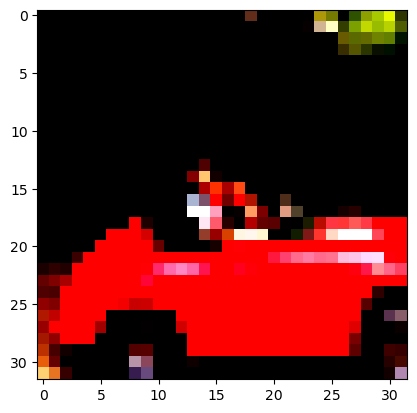

In [19]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))
plt.show()

In [36]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in [0,2]]
cifar2_val = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in [0,2]]


데이터셋의 일부만 사용하려 할 때, 위 코드처럼 처리하긴 어려울 수 있다. `Dataset`은 내부적으로 `__len__`과 `__getitem__`이 정의됐기 때문에 위 코드가 가능하다. 실제로는 인덱스 값을 알 때, `torch.utils.data.Subset`을 사용해서 설정할 수 있다. iterable한 데이터라면 `ChainDataset`을 이용할 수 있다.


이미지 데이터를 긴 1차원 데이터로 변환한다면 아래 그림과 같다. 즉 32$\times$32$\times$3 형태의 데이터를 3072개의 피쳐를 가진 데이터로 생각해볼 수 있는 것이다.
![image](https://user-images.githubusercontent.com/76675506/189508939-86d033ff-06ac-4fe4-a178-4edc14042655.png)




In [21]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,
        512,
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out,
    )
)

위 신경망을 거친 결과는 각 레이블에 대한 확률값으로 나오게 만들어야 한다. 이를 위해  **somftmax**를 사용한다.
softmax는 벡터를 요소 단위로 지수 연산을 한 값을 지수 값의 총합으로 나눈다.

$y_k = \frac{e^{a_k}}{\sum_{i=1}^{n}e^{a_i}}$

그런데 이 때 **e에 대한 지수함수로 나타내는 이유**는 뭘까? 이는  *sofmax가 sigmoid 함수로부터 유도됐기 때문이다. 그 외에 얻을 수 있는 장점은 아래와 같다.
- 단조 증가함수가 되기 때문에 softmax의 파라미터들의 대소 관계는 변하지 않게 된다.
- 지수함수로 인해 값의 차이가 아무리 작아도 구별할 수 있을만큼 커진다.
- $e^{x}$의 미분은 원래 값과 동일하기 때문에 미분이 편리하다.
또한 단조 증가함수가 되기 때문에 softmax의 파라미터들의 대소 관계는 변하지 않게 된다.

softmax 함수는 또한 **scale invariant**하다. 즉, 비율이 유지되지 않는다. 하지만 학습 과정에서 가중치를 통해 적절한 비율로 맞춰준다.

https://gooopy.tistory.com/53

In [22]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [23]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [24]:
softmax(x).sum()

tensor(1.)

`softmax`를 사용할 때는 어떤 차원에 대해 실행할 것인지 명시해야 한다.

In [28]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                 [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [29]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


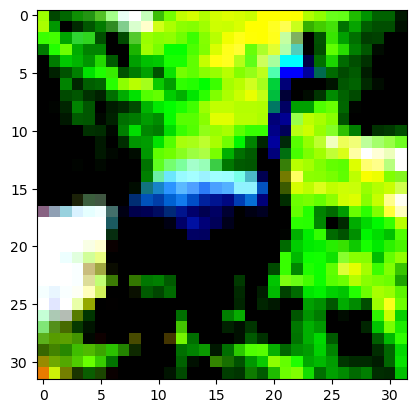

In [37]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [39]:
img_batch = img.view(-1).unsqueeze(0)

img_batch.shape

torch.Size([1, 3072])

In [40]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [46]:
_, index = torch.max(out, dim=1) # 0으로 하면 배치중에 가장 큰값을 찾게 된다.

index

tensor([1])

**가능도(우도)(Likelihood)**: 어떤 값이 관측되었을 때, 이것이 어떤 확률 분포에서 왔을 지에 대한 확률

**NLL(Negative Log Likelihood)(=Cross Entropy)**: 가능도가 높을 때는 값을 낮게 출력하고 가능도가 낮을 때는 값을 높게 출력하는 손실 함수. 지도학습에선 정답 클래스에 대한 예측 확률 값에 대해 적용한다.
`NLL = - sum(log(out_i[c_i]))` $N$ 개의 샘플에 대해 `sum`을 진행한다.

https://jjangjjong.tistory.com/41

In [48]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # 확률값을 로그로 받을 때 0에 가까우면 문제가 되므로 LogSoftmax를 사용한다.
)

In [50]:
loss = nn.NLLLoss()

In [53]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.7302, grad_fn=<NllLossBackward0>)

아래 그림을 보면 왼쪽의 크로스 엔트로피 손실함수는 예측이 정답과 차이가 클 경우 기울기 값이 존재한다. 하지만 오른쪽 MSE의 경우는 정답과 차이가 클 경우에도 포화되버려 분류 문제에 적합하지 않다는 것을 알 수 있다.

![](.notepad_images/6dc2801e.png)

코드 실행이 너무 오래 걸려 GPU 위에서 연산할 수 있게끔 책의 코드 변경했다.

In [62]:
import torch.optim as optim
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)).to(device='cuda')
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        img=img.to(device='cuda') # GPU 연산
        label=torch.Tensor(label).to(device='cuda') # GPU 연산
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument target in method wrapper_nll_loss_forward)

각 에포크마다 샘플을 섞은 후 한번에 하나 혹은 여러 개의 샘플에 대해 기울기를 평가하면 경사 하강에 랜덤한 효과를 넣어줄 수 있다. 즉 SGD와 같은 효과를 얻을 수 있다.

이를 구현하기 위해 `DataLoader`를 사용한다. `DataLoader`를 사용하면 미니 배치에 포함될 샘플을 원하는 샘플링 전략에 따라 선택할 수 있다.

In [64]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
).to(device='cuda')

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(),lr = learning_rate)
loss_fn=nn.NLLLoss()

n_epochs=100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs=imgs.to(device='cuda')
        labels=labels.to(device='cuda')

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 0.271369
Epoch: 1, Loss: 0.284412
Epoch: 2, Loss: 0.516378
Epoch: 3, Loss: 0.544816
Epoch: 4, Loss: 0.411680
Epoch: 5, Loss: 0.225756
Epoch: 6, Loss: 0.475594
Epoch: 7, Loss: 0.428931
Epoch: 8, Loss: 0.416570
Epoch: 9, Loss: 0.214373
Epoch: 10, Loss: 0.651137
Epoch: 11, Loss: 0.301799
Epoch: 12, Loss: 0.236530
Epoch: 13, Loss: 0.234512
Epoch: 14, Loss: 0.425123
Epoch: 15, Loss: 0.352489
Epoch: 16, Loss: 0.192475
Epoch: 17, Loss: 0.474046
Epoch: 18, Loss: 0.361485
Epoch: 19, Loss: 0.279097
Epoch: 20, Loss: 0.090803
Epoch: 21, Loss: 0.336125
Epoch: 22, Loss: 0.222032
Epoch: 23, Loss: 0.173837
Epoch: 24, Loss: 0.221882
Epoch: 25, Loss: 0.186024
Epoch: 26, Loss: 0.421147
Epoch: 27, Loss: 0.265013
Epoch: 28, Loss: 0.121429
Epoch: 29, Loss: 0.458642
Epoch: 30, Loss: 0.335254
Epoch: 31, Loss: 0.171029
Epoch: 32, Loss: 0.109618
Epoch: 33, Loss: 0.236208
Epoch: 34, Loss: 0.107412
Epoch: 35, Loss: 0.176962
Epoch: 36, Loss: 0.165231
Epoch: 37, Loss: 0.255428
Epoch: 38, Loss: 0.068

In [65]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs=imgs.to(device='cuda')
        labels=labels.to(device='cuda')

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f", correct / total)


Accuracy: %f 0.9995


모델에 계층을 더 추가한다면 아래와 같이 만들 수 있다. 줄어드는 중간 아웃풋은 정보가 잘 압축되라는 의도이다.

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),
    nn.LogSoftmax(dim=1)
).to(device='cuda')

`nn.LogSoftmax`와 `nn.NLLLoss`의 조합은 `nn.CrossEntropy`와 동일하다. 차이점이 있다면,
`nn.LogSoftmax`는 타깃에 모든 것을 담아 넣는 디랙 분포(Dirac distributiona)와 로그 확률 입력으로 주어지는 예측 분포 사이의 크로스엔트로피로 볼 수 있다.

일반적으로 신경망의 마지막 계층에서는 `nn.LogSoftmax` 대신 `nn.CrossEntropy`를 사용한다. 대신 모델의 출력을 확률로 해석할 수 없다는 단점이 있다. 만약 해석이 필요하다면 출력을 다시 `Softmax`에 연결해야 한다.

![image](https://user-images.githubusercontent.com/76675506/189515476-28c2b43d-e022-4a95-b166-bfc4241f81e8.png)

In [69]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),
).to(device='cuda')

loss_fn = nn.CrossEntropyLoss()

In [70]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(),lr = learning_rate)

n_epochs=100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs=imgs.to(device='cuda')
        labels=labels.to(device='cuda')

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 0.412174
Epoch: 1, Loss: 0.354892
Epoch: 2, Loss: 0.229119
Epoch: 3, Loss: 0.390950
Epoch: 4, Loss: 0.423762
Epoch: 5, Loss: 0.322943
Epoch: 6, Loss: 0.257946
Epoch: 7, Loss: 0.261611
Epoch: 8, Loss: 0.286233
Epoch: 9, Loss: 0.433633
Epoch: 10, Loss: 0.396331
Epoch: 11, Loss: 0.681109
Epoch: 12, Loss: 0.312837
Epoch: 13, Loss: 0.182106
Epoch: 14, Loss: 0.313424
Epoch: 15, Loss: 0.399135
Epoch: 16, Loss: 0.254134
Epoch: 17, Loss: 0.470419
Epoch: 18, Loss: 0.580032
Epoch: 19, Loss: 0.479715
Epoch: 20, Loss: 0.522276
Epoch: 21, Loss: 0.286045
Epoch: 22, Loss: 0.233641
Epoch: 23, Loss: 0.147793
Epoch: 24, Loss: 0.253355
Epoch: 25, Loss: 0.659954
Epoch: 26, Loss: 0.186054
Epoch: 27, Loss: 0.319943
Epoch: 28, Loss: 0.400769
Epoch: 29, Loss: 0.438698
Epoch: 30, Loss: 0.165513
Epoch: 31, Loss: 0.148061
Epoch: 32, Loss: 0.101703
Epoch: 33, Loss: 0.228430
Epoch: 34, Loss: 0.138280
Epoch: 35, Loss: 0.177222
Epoch: 36, Loss: 0.089506
Epoch: 37, Loss: 0.068462
Epoch: 38, Loss: 0.131

모델이 과적합 됐음을 아래 코드를 통해 확인할 수 있다. 이는 모델이 데이터셋에 대해 단순 암기를 해버린 것과 같다.

In [71]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs=imgs.to(device='cuda')
        labels=labels.to(device='cuda')

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f", correct / total)
# 과적합

Accuracy: %f 1.0


모델의 파라미터 개수가 370만개가 넘는다. 이는 픽셀 수에 따라 확장 가능하기 어렵다는 뜻이 된다. 1024$\times$1024 이미지를 분류하기 위해선 약 30억개의 파라미터가 필요하게 된다.

In [73]:
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

이는 **완전 연결**의 한계점이다. 입력으로 들어온 이미지의 정보 하나하나를 사용하고 출력 피처 하나하나에 대해 각 정보의 선형 조합을 계산한다.

예를 들어 32$\times$32 크기의 하늘을 나는 비행기 이미지가 입력으로 들어왔다고 가정해보자. 이 경우 완전 연결 신경망은 픽셀 하나하나를 따져본다. 그리고 이 이미지가 비행기임을 학습한다. 문제는 비행기를 한 픽셀 이상 위치를 이동하면 각 픽셀 간의 관계를 처음부터 다시 파악해야 한다는 것이다. 이를 다른말로 **평행이동 불변성**(**Translation invarance**)가 없다고 표현한다.

![image](https://user-images.githubusercontent.com/76675506/189516319-0f6e8e14-b0a2-4874-ab77-8d8321246d5c.png)

## 연습 문제
---
1. `torchvision`을 사용하여 데이터를 임의로 잘라내보자.
    - 원래의 이미지와 비교하여 어떤 점이 다른가?
    - 동일한 이미지를 다시 처리하면 어떻게 되는가?
    - 랜덤하게 크롭된 이미지로 훈련시킨 결과는 어떠한가?

TypeError: Invalid shape (32, 32, 32) for image data

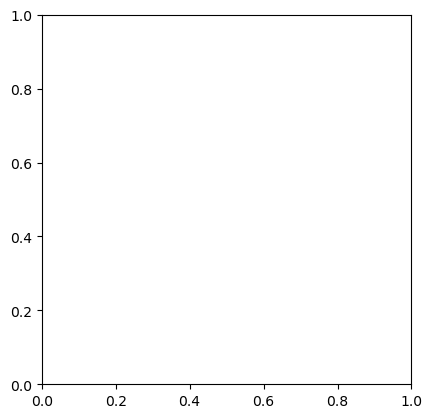

In [96]:
transformer = transforms.RandomCrop(32,32)
img, _ = cifar2[0]

# plt.imshow(img.permute(1, 2, 0))

plt.imshow(transformer(img.permute(1,2,0)))
plt.show()

2. MSE로 손실 함수를 바꿔보자
    - 훈련 방식이 바뀌는가?

3. 과적합이 일어나지 않을 정도로 신경망의 용량을 줄이는 것이 가능한가?
    - 이렇게 할 경우 검증셋에서의 모델 성능은 어떠한가?